In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

2023-06-21 00:17:08.788015: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 00:17:08.921634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 00:17:09.474142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


importing Jupyter notebook from utils.ipynb


In [2]:
df_train = pd.read_csv(train_csv_path, sep=",")
df_train["img_path"] =  df_train['image_id'].apply(build_image_path, convert_dtype=str)

In [3]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

Número de imagens no conjunto de treinamento:  34995
Distribuição de cancer conjunto de treinamento:     cancer   qtde
0       0  34222
1       1    773
Número de imagens no conjunto de validação:  8749
Distribuição de cancer no conjunto de validação:     cancer  qtde
0       0  8556
1       1   193


In [4]:
# Nesse momento, vou aplicar o undersampling escolhendo aleatoriamente 900 imagens sem cancer no conjunto de treinamento. 
df_train_split = pd.concat([df_train_split[df_train_split["cancer"]==1], df_train_split[df_train_split["cancer"]==0].sample(n=900)])
df_train_split = df_train_split.sample(n=df_train_split.shape[0])
print(df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
df_train_split.iloc[0]['img_path']

   cancer  qtde
0       0   900
1       1   773


PosixPath('/home/kasco/MDC/FinalProject/BreastCancerDetection/Datasets/Originals/274766802.png')

In [5]:
# Já para validação, vou escolher 230 imagens seguindo a mesma ideia.
df_val_split = pd.concat([df_val_split[df_val_split["cancer"]==1], df_val_split[df_val_split["cancer"]==0].sample(n=230)])
df_val_split = df_val_split.sample(n=df_val_split.shape[0])
print(df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
df_val_split

   cancer  qtde
0       0   230
1       1   193


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
20091,1,37032,1291044944,L,MLO,76.0,1,1,1,0.0,0,C,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
36509,2,59276,1762485764,L,MLO,51.0,0,0,0,NaN,0,NaN,48,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
33764,1,55724,1047632861,R,CC,60.0,0,0,0,1.0,0,A,216,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
30669,2,51276,1416534699,L,CC,54.0,1,1,0,NaN,0,NaN,21,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
34266,1,56381,802070687,R,CC,67.0,0,0,0,1.0,0,C,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1,11330,1859340051,L,CC,50.0,0,0,0,1.0,0,D,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
25686,1,44645,1107100062,R,MLO,67.0,0,0,0,NaN,0,B,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
39297,1,63056,1783998558,R,MLO,67.0,1,1,1,0.0,0,C,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
8638,1,21678,351625203,L,CC,61.0,0,0,0,1.0,0,B,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...


In [6]:
# Iremos agora criar 4 diretórios (2 de teste e 2 de validação, um de positivos e outro de negativos para cancer)

# Criando os diretórios:
create_dataset_dirs()
    
# Criando os subdiretórios
build_train_dataset_from_ori_imgs(df_train_split)
    
build_val_dataset_from_ori_imgs(df_val_split)

In [7]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator(rescale = 1./255., zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
        val_dir_path,
        target_size = (img_height, img_width),
        batch_size = 16,
        class_mode = 'binary')

Found 4223 images belonging to 2 classes.
Found 1071 images belonging to 2 classes.


In [9]:
model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (img_height, img_width, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
model = Sequential()
model.add(model_resnet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

2023-06-21 00:17:15.873418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 00:17:15.929328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 00:17:15.929447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 8, 2048)       23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
______________________________________

In [11]:
print("Num GPUs Available: ", tf.config.list_physical_devices())

device='/GPU:0'

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)


history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15


2023-06-21 00:17:18.398112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-21 00:17:21.301101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-21 00:17:22.028463: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-21 00:17:22.379865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-21 00:17:24.305602: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2183b640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-21 00:17:24.305628: I tensorflow/co

20/20 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.7453

2023-06-21 00:17:33.123483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 24s 934ms/step - loss: 0.7229 - accuracy: 0.7453 - val_loss: 0.5383 - val_accuracy: 0.8198
Epoch 2/15
20/20 [==============================] - 17s 870ms/step - loss: 0.5344 - accuracy: 0.7953 - val_loss: 0.4836 - val_accuracy: 0.8198
Epoch 3/15
20/20 [==============================] - 14s 723ms/step - loss: 0.4998 - accuracy: 0.8109 - val_loss: 0.4756 - val_accuracy: 0.8198
Epoch 4/15
20/20 [==============================] - 14s 709ms/step - loss: 0.5094 - accuracy: 0.8031 - val_loss: 0.4767 - val_accuracy: 0.8198
Epoch 5/15
20/20 [==============================] - 14s 723ms/step - loss: 0.4714 - accuracy: 0.8250 - val_loss: 0.4703 - val_accuracy: 0.8198
Epoch 6/15
20/20 [==============================] - 17s 872ms/step - loss: 0.4479 - accuracy: 0.8438 - val_loss: 0.4807 - val_accuracy: 0.8198
Epoch 7/15
20/20 [==============================] - 16s 801ms/step - loss: 0.4903 - accuracy: 0.8156 - val_loss: 0.4760 - val_accuracy: 0.8198
Epoch 8/15

In [13]:
model.save('baseline_resnet50.h5')

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0, 0.5, 'loss')

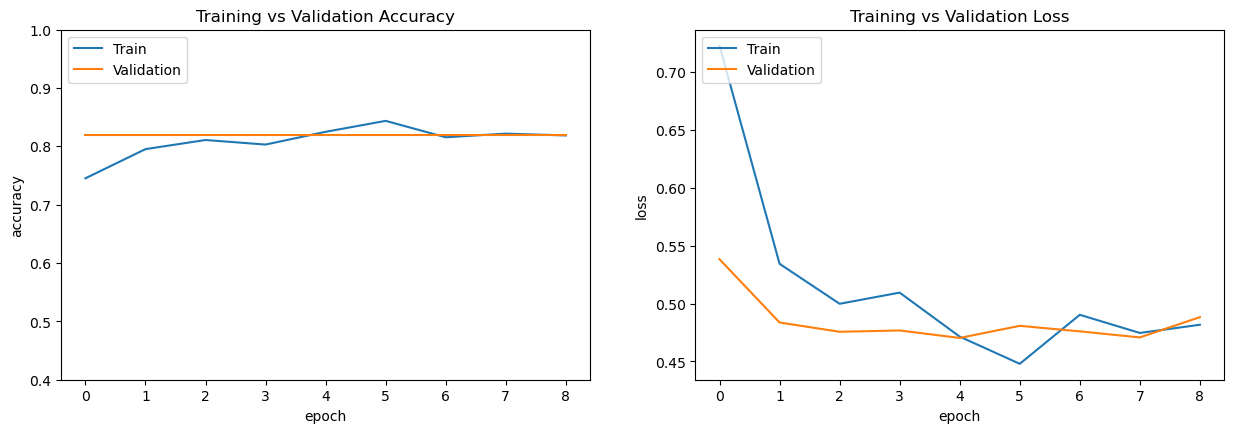

In [15]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

2023-06-21 00:21:43.608834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


67/67 [==============================] - 7s 95ms/step


Text(50.722222222222214, 0.5, 'Real')

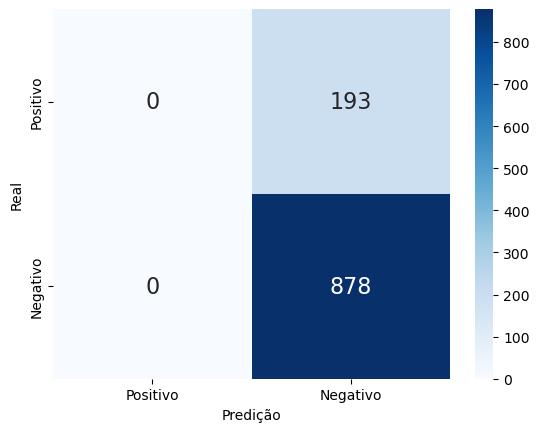

In [17]:
model_resnet50 = load_model('baseline_resnet50.h5')

pred_resnet50 = model_resnet50.predict(validation_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

In [ ]:
pred_resnet50

array([[0.4880886 ],
       [0.48577598],
       [0.48603916],
       [0.48556837],
       [0.4877001 ],
       [0.4844164 ],
       [0.4813858 ],
       [0.48583165],
       [0.48577547],
       [0.49178883],
       [0.48698848],
       [0.48774108],
       [0.48653415],
       [0.49147406],
       [0.48385492],
       [0.4921746 ],
       [0.47986105],
       [0.48772487],
       [0.4829138 ],
       [0.4901997 ],
       [0.48487046],
       [0.48377335],
       [0.4834619 ],
       [0.46315557],
       [0.4834677 ],
       [0.49120805],
       [0.48165575],
       [0.48341566],
       [0.47838426],
       [0.48488468],
       [0.48730308],
       [0.4914529 ],
       [0.48209733],
       [0.48158595],
       [0.4831799 ],
       [0.4802841 ],
       [0.48761886],
       [0.49201065],
       [0.47878593],
       [0.4883452 ],
       [0.4862027 ],
       [0.48348406],
       [0.48015985],
       [0.49066576],
       [0.4898425 ],
       [0.4893228 ],
       [0.48451167],
       [0.480

In [ ]:
from keras.applications.vgg16 import VGG16

model_vgg16 = VGG16(weights = 'imagenet', input_shape = (1024, 512, 3), include_top = False)

for layer in model_vgg16.layers:
    layer.trainable = False
    
model2 = Sequential()
model2.add(model_vgg16)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 32, 16, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
_______________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model2.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 10, epochs = 10, callbacks = callback)

Epoch 1/10


2023-06-16 23:38:09.748304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.5813  

2023-06-16 23:59:19.931621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 2513s 251s/step - loss: 0.7166 - accuracy: 0.5813 - val_loss: 0.6868 - val_accuracy: 0.5461
Epoch 2/10
10/10 [==============================] - 2208s 242s/step - loss: 0.7026 - accuracy: 0.5455 - val_loss: 0.6969 - val_accuracy: 0.4870
Epoch 3/10
10/10 [==============================] - 2118s 224s/step - loss: 0.6885 - accuracy: 0.5556 - val_loss: 0.6852 - val_accuracy: 0.5532
Epoch 4/10
10/10 [==============================] - 2182s 231s/step - loss: 0.6773 - accuracy: 0.5813 - val_loss: 0.6868 - val_accuracy: 0.5508
Epoch 5/10
10/10 [==============================] - 2114s 224s/step - loss: 0.6815 - accuracy: 0.5758 - val_loss: 0.6825 - val_accuracy: 0.5721
Epoch 6/10
10/10 [==============================] - 2182s 231s/step - loss: 0.7039 - accuracy: 0.5469 - val_loss: 0.6950 - val_accuracy: 0.5154
Epoch 7/10
10/10 [==============================] - 2184s 232s/step - loss: 0.6890 - accuracy: 0.5688 - val_loss: 0.6900 - val_accuracy: 0.5461
Epo

In [ ]:
model2.save('baseline_vgg16.h5')

Text(0, 0.5, 'loss')

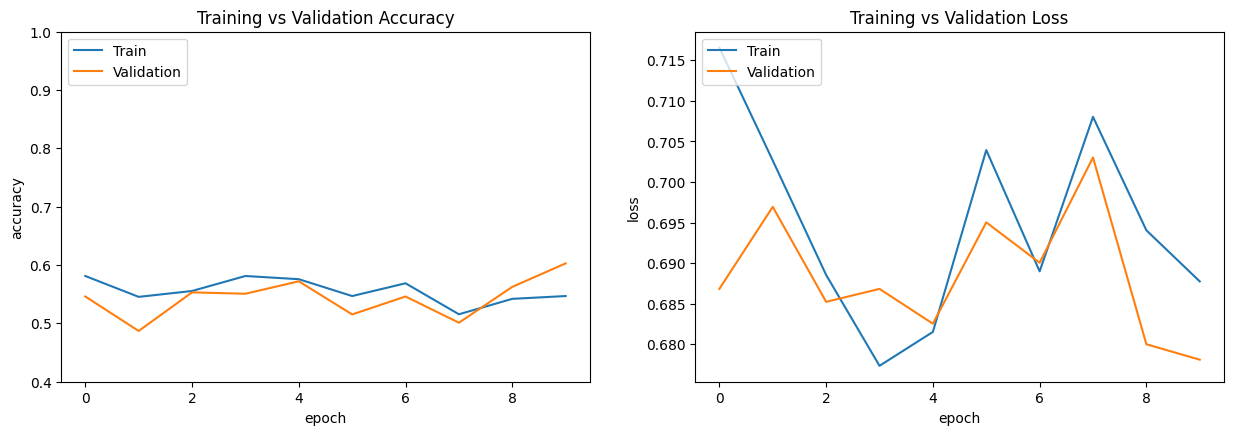

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

2023-06-17 07:54:32.342350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1448s 53s/step


Text(50.722222222222214, 0.5, 'Real')

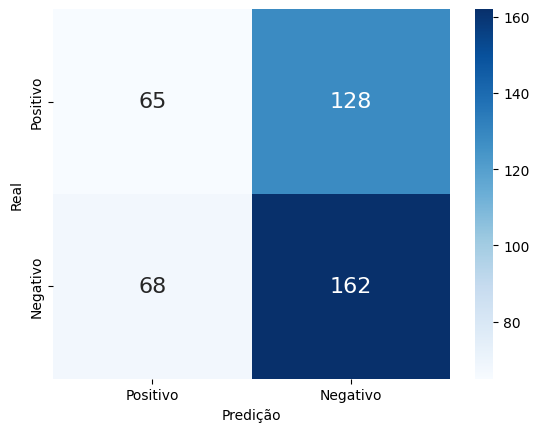

In [ ]:
model_vgg16 = load_model('baseline_vgg16.h5')

pred_vgg16 = model_vgg16.predict(validation_generator)

y_pred_vgg16 = []
for prob in pred_vgg16:
    if prob >= 0.5:
        y_pred_vgg16.append(1)
    else:
        y_pred_vgg16.append(0)
        
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_vgg16)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")